# Synthetic Data Generation + Usage Example

In [1]:
import os
os.chdir(f"/home/{os.getlogin()}/watttime-python-client-aer-algo")

import pandas as pd
import evaluation.eval_framework as evu
import math

import seaborn as sns
import matplotlib.pyplot as plt
import evaluation.metrics as m

username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")

## Step 1: Generate a year of data
- two random dates chosen per week
- Max date is yesterday
- duplicate dates removed

In [2]:
dates_2023 = evu.generate_random_dates(2023)
dates_2024 = evu.generate_random_dates(2024)
distinct_date_list = dates_2023 + dates_2024

## Step 2: Set keyword parameters + generate dataframe

### Example: At home EV charging

- Covers a 5.5 - 8.5 hour variable length window
- The vehicle has a BMW and has an average power draw of 42.5
- Battery is usually typically 50% charged at plug in time.
- Charging occurs during the workday

In [3]:
ev_kwargs = {
    "power_output_max_rates": [42.5], # BMW average
    "max_percent_capacity": 0.95,  # highest level of charge achieved by battery
    "power_output_efficiency": 0.75,  # power loss. 1 = no power loss.
    "average_battery_starting_capacity": 0.5,  # average starting percent charged
    "start_hour": "09:00:00",  # earliest session can start
    "end_hour": "17:00:00",  # latest session can start
}

### Example: AI Model Training

- Model training can occur at any time of day
- There are 3 server models that consume 240, 310, and 400 watt-hour on average
- Early stopping is not an option

In [4]:
# criteria
ai_kwargs = {
    "power_output_max_rates": [240,310,400], # assuming a bare metal usecase, k8s or vm rescale to vCPU
    "start_hour": "00:00:00",  # earliest session can start
    "end_hour": "23:59:00",  # latest session can start
    "user_charge_tolerance":1.0 # job must run to completion
}

## Step 3: Generate dataframe for x # of synthetic users
- synthetic user = user behavior + device characteristics

In [8]:
# generating data for 1 vehicle
df_ev = evu.execute_synth_data_process(
    distinct_date_list=distinct_date_list, number_of_users=1, **ev_kwargs
)

100%|██████████| 1/1 [00:00<00:00, 47.78it/s]


In [9]:
# generating data for 5 AI models
df_ai = evu.execute_synth_data_process(
    distinct_date_list=distinct_date_list, number_of_users=5, **ai_kwargs
)

100%|██████████| 5/5 [00:00<00:00, 48.63it/s]


In [6]:
df_ai.session_start_time.sample(1)

285   2023-11-25 11:02:17
Name: session_start_time, dtype: datetime64[ns]

In [30]:
df_ai.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 965 entries, 0 to 964
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   index                         965 non-null    int64         
 1   distinct_dates                965 non-null    object        
 2   user_type                     965 non-null    object        
 3   session_start_time            965 non-null    datetime64[ns]
 4   session_end_time              965 non-null    datetime64[ns]
 5   initial_charge                965 non-null    float64       
 6   total_seconds_to_95           965 non-null    float64       
 7   full_charge_time              965 non-null    datetime64[ns]
 8   length_of_session_in_seconds  965 non-null    float64       
 9   charged_kWh_actual            965 non-null    float64       
 10  final_perc_charged            965 non-null    float64       
 11  final_charge_time             96

In [29]:
df_ai[["length_of_session_in_seconds", "session_start_time","session_end_time","total_intervals_plugged_in","power_output_rate"]].head(5).values

array([[22526.456704, Timestamp('2023-01-03 03:17:26'),
        Timestamp('2023-01-03 09:32:52.456704'), 75.08818901333333,
        326.4],
       [25685.231872, Timestamp('2023-01-04 06:20:50'),
        Timestamp('2023-01-04 13:28:55.231872'), 85.61743957333333,
        326.4],
       [25384.434752, Timestamp('2023-01-13 11:05:16'),
        Timestamp('2023-01-13 18:08:20.434752'), 84.61478250666667,
        326.4],
       [29067.455693, Timestamp('2023-01-14 13:56:37'),
        Timestamp('2023-01-14 22:01:04.455693'), 96.89151897666666,
        326.4],
       [32333.332139, Timestamp('2023-01-19 07:52:55'),
        Timestamp('2023-01-19 16:51:48.332139'), 107.77777379666666,
        326.4]], dtype=object)

In [27]:
df_ai.head().T

,0,1,2,3,4
index,0,1,2,3,4
distinct_dates,2023-01-03,2023-01-04,2023-01-13,2023-01-14,2023-01-19
user_type,r326.4_tc118_avglc27276_sdlc6935,r326.4_tc118_avglc27276_sdlc6935,r326.4_tc118_avglc27276_sdlc6935,r326.4_tc118_avglc27276_sdlc6935,r326.4_tc118_avglc27276_sdlc6935
session_start_time,2023-01-03 03:17:26,2023-01-04 06:20:50,2023-01-13 11:05:16,2023-01-14 13:56:37,2023-01-19 07:52:55
session_end_time,2023-01-03 09:32:52.456704,2023-01-04 13:28:55.231872,2023-01-13 18:08:20.434752,2023-01-14 22:01:04.455693,2023-01-19 16:51:48.332139
initial_charge,0.423465,0.537993,0.49766,0.509566,0.534225
total_seconds_to_95,685.269388,536.215432,588.707191,573.212247,541.118821
full_charge_time,2023-01-03 03:28:51.269388232,2023-01-04 06:29:46.215432289,2023-01-13 11:15:04.707190772,2023-01-14 14:06:10.212247100,2023-01-19 08:01:56.118820789
length_of_session_in_seconds,22526.456704,25685.231872,25384.434752,29067.455693,32333.332139
charged_kWh_actual,62.131091,48.616866,53.376119,51.971244,49.06144


## Synth Data Distributions

Text(0.5, 1.0, 'EV Synthetic Data - Charging Session Length (seconds)')

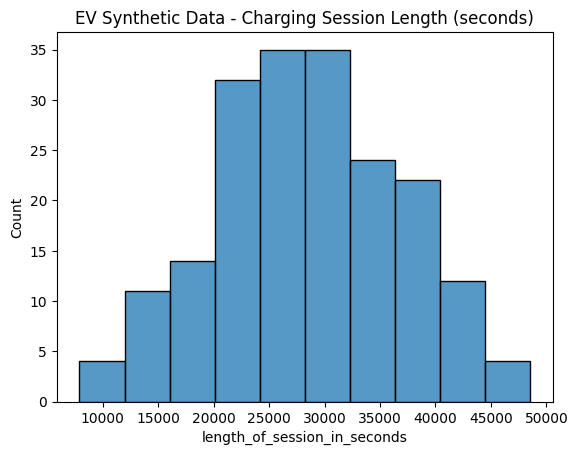

In [10]:
sns.histplot(df_ev["length_of_session_in_seconds"]).set_title(
    "EV Synthetic Data - Charging Session Length (seconds)"
)

Text(0.5, 1.0, 'AI Synthetic Data - Training Session Length (seconds)')

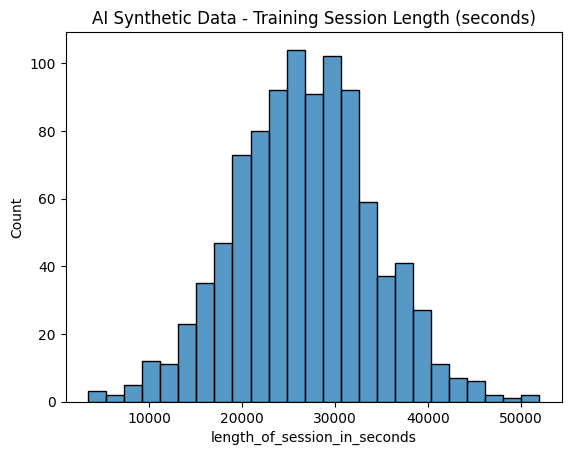

In [11]:
sns.histplot(df_ai["length_of_session_in_seconds"]).set_title(
    "AI Synthetic Data - Training Session Length (seconds)"
)

## Step 3: Get MOER forecast and actuals

In [12]:
# taking a subset of data - this takes a while to run
synth_data = df_ai.sample(2)
region = "SPP_SIOUX"

In [13]:
def sanitize_time_needed(x,y):
    return int(math.ceil(min(x, y) / 300.0) * 5)

def sanitize_total_intervals(x):
    return math.ceil(x)

synth_data["moer_forecast"] = synth_data.apply(
    lambda x: evu.get_historical_fcst_data(
        x.session_start_time, 
        sanitize_total_intervals(x.total_intervals_plugged_in),
        region=region
    ),
    axis=1,
)

synth_data["moer_actual"] = synth_data.apply(
    lambda x: evu.get_historical_actual_data(
        x.session_start_time, 
        sanitize_total_intervals(x.total_intervals_plugged_in),
        region=region
    ),
    axis=1,
)

## Step 4: Optimize

- For this use case we can use the simplest optimizer give that we have no additional constraints

In [14]:
def run_optimization_functions(df: pd.DataFrame, contiguous=False):
    # Lambda functions for common operations
    get_charging_schedule = lambda x: x["usage"].values.flatten()
    get_total_emissions = lambda x: x["emissions_co2e_lb"].sum()
    
    # Sanitize input data
    df["sanitize_intervals_plugged_in"] = df.apply(lambda x: sanitize_total_intervals(x.total_intervals_plugged_in), axis=1)
    df["sanitize_time_needed"] = df.apply(lambda x: sanitize_time_needed(x.total_seconds_to_95, x.length_of_session_in_seconds), axis=1)
    
    # Helper function for charge_per_interval
    def charge_per_interval_func(x, contiguous=False):
        return [(0, x)] if contiguous else []
    
    # Function to apply optimization
    def apply_optimization(row, moer_data, optimization_method):
        return evu.get_schedule_and_cost_api(
            usage_power_kw=row.power_output_rate,
            time_needed=row.sanitize_time_needed,
            total_time_horizon=row.sanitize_intervals_plugged_in,
            moer_data=moer_data,
            optimization_method=optimization_method,
            charge_per_interval=charge_per_interval_func(row.sanitize_time_needed, contiguous=contiguous)
        )
    
    # Apply optimizations
    df["optimizer_baseline"] = df.apply(lambda x: apply_optimization(x, x.moer_actual, "baseline"), axis=1)
    df["optimizer_ideal"] = df.apply(lambda x: apply_optimization(x, x.moer_actual, "auto"), axis=1)
    df["optimizer_simple"] = df.apply(lambda x: apply_optimization(x, x.moer_forecast, "auto"), axis=1)
    
    # Calculate emissions and charging schedules
    df["charging_schedule"] = df["optimizer_simple"].apply(get_charging_schedule)
    df["baseline_emissions"] = df["optimizer_baseline"].apply(get_total_emissions)
    df["ideal_charging_schedule"] = df["optimizer_ideal"].apply(get_charging_schedule)
    df["ideal_emissions"] = df["optimizer_ideal"].apply(get_total_emissions)
    df["forecast_emissions"] = df["optimizer_simple"].apply(get_total_emissions)
    
    # Calculate actual emissions
    df["actual_emissions"] = df.apply(
        lambda x: evu.get_total_emission(
            x.moer_actual["value"],
            x.optimizer_simple.energy_usage_mwh
        ),
        axis=1
    )
    
    return df

In [15]:
synth_data = run_optimization_functions(synth_data, contiguous=False)

Charge per interval: []
== Baseline fit! ==
Charge per interval: []
== Baseline fit! ==
Charge per interval: []
== Simple fit! ==
Charge per interval: []
== Simple fit! ==
Charge per interval: []
== Simple fit! ==
Charge per interval: []
== Simple fit! ==


## Step 5: Results

In [16]:
synth_data[["distinct_dates","user_type","baseline_emissions","ideal_emissions","forecast_emissions","actual_emissions"]]

,distinct_dates,user_type,baseline_emissions,ideal_emissions,forecast_emissions,actual_emissions
191,2024-11-02,r326.4_tc118_avglc27276_sdlc6935,83.694400,4.270400,43.536320,43.302400
646,2023-08-27,r217.30999999999997_tc60_avglc27278_sdlc7364,49.655335,48.442021,48.614058,50.035627


In [52]:
em = m.EvalMetrics(
    baseline_col= "baseline_emissions",
    ideal_col="ideal_emissions", 
    forecast_col="forecast_emissions",
    actuals_col="actual_emissions"
    )

In [53]:
em.calculate_results(synth_data,keep_cols = ["distinct_dates","user_type"], percent=False)

,distinct_dates,user_type,emissions_avoided,expected_avoidance,nearness_to_ideal,forecast_error
0,2024-07-24,r332.8_tc108_avglc20487_sdlc7127,3.2448,-10.22528,-9.781547,13.47008
1,2024-03-06,r264.0_tc86_avglc28288_sdlc7267,29.6120,-15.28780,11.002200,44.89980


In [54]:
em.calculate_results(synth_data,keep_cols = ["distinct_dates","user_type"],percent=True)

,distinct_dates,user_type,emissions_avoided_percent,expected_avoidance_percent,nearness_to_ideal_percent,forecast_error_percent
0,2024-07-24,r332.8_tc108_avglc20487_sdlc7127,2.713987,-8.552540,-8.211874,12.320219
1,2024-03-06,r264.0_tc86_avglc28288_sdlc7267,84.600880,-43.676933,126.287879,227.753599
